In [3]:
import h5py
import mdtraj as md
import torch
from loguru import logger
from tqdm import tqdm
import matplotlib.pyplot as plt

from rocketshp import config

2024-11-15 09:25:34.117 | INFO     | rocketshp.config:<module>:13 - PROJ_ROOT path is: /mnt/home/ssledzieski/Projects/rocketshp


In [4]:
ATLAS_DATA_DIR = config.RAW_DATA_DIR / "atlas"
ATLAS_PROCESSED_DATA_DIR = config.PROCESSED_DATA_DIR / "atlas"

In [5]:
from rocketshp.dataset import ATLASDataModule, ATLASDataset, _unstack_variable_length_tensors

/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [11]:
adl = ATLASDataModule(ATLAS_PROCESSED_DATA_DIR / "atlas_processed.h5", seq_features=True, struct_features=True, batch_size=5, num_workers=0, train_pct=0.8, val_pct=0.1)
adl.setup("train")
ads = adl.dataset

In [12]:
from rocketshp.modeling.architectures import StructEncoder, SeqEncoder, JointStructAndSequenceEncoder, FlexibilityModel

In [6]:
# fm = FlexibilityModel(1536, 1, 128, 8, 4)
# fm.train()

# loss_fn = torch.nn.MSELoss()

# losses = []
# optimizer = torch.optim.Adam(fm.parameters(), lr=1e-3)
# for epoch in range(1):
#     # logger.info(f"Epoch {epoch}")
#     for batch in tqdm(adl.train_dataloader(),leave=False):
#         (seq, struct), mask, y = batch
#         y_hat = fm((seq, struct))
#         loss = compute_masked_mse_loss(y_hat, y.unsqueeze(2), mask)
#         losses.append(loss.item())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [13]:
import torch

def load_checkpoint(chkpt):
    """
    FlexibilityModel(1536, 1, 128, 8, 4)
    """
    chk = torch.load(chkpt)
    hp = chk["hyper_parameters"]
    state_dict = {}
    fm = FlexibilityModel(hp["embedding_dim"], hp["output_dim"], hp["d_model"], hp["n_heads"], hp["n_layers"])
    for k,v in chk["state_dict"].items():
        new_k = k.replace("child_model.","")
        state_dict[new_k] = v
    fm.load_state_dict(state_dict)
    fm.eval()
    return fm


In [14]:
# fmnew = load_checkpoint("/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/rmsf_full_02/model-epoch=04-train_loss=0.05.pt.ckpt")
# fmnew = load_checkpoint("/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/nepTest2/model-epoch=19-train_loss=0.01.pt.ckpt")
fmnew = load_checkpoint("/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/rmsf_full_04/model-epoch=16-train_loss=0.01.pt.ckpt")

/tmp/ipykernel_2116615/3689996144.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(chkpt)


In [15]:
from dataclasses import dataclass
from pathlib import Path
import omegaconf
@dataclass
class PARAMETERS:
    batch_size: int = 64
    lr: float = 0.007
    max_epochs: int = 20
    num_data_workers: int = 31
    shuffle: bool = True
    precision: str = "highest"
    num_parameters: int = 0

p = PARAMETERS()
config = omegaconf.OmegaConf.create(p)
newp = omegaconf.OmegaConf.load("../configs/config.yml")
config.update(newp)


In [16]:
len(adl.dataset), len(adl.train_data), len(adl.val_data), len(adl.test_data)

(4167, 3333, 414, 420)

In [51]:
import torch.nn as nn

2024-11-15 09:28:16.865 | INFO     | __main__:<module>:25 - Protein: 1fxo_G/R1
2024-11-15 09:28:16.866 | INFO     | __main__:<module>:26 - Spearman: SignificanceResult(statistic=0.8669509694569305, pvalue=5.304942075923113e-90)
2024-11-15 09:28:16.866 | INFO     | __main__:<module>:27 - Pearson: PearsonRResult(statistic=0.7551891848731316, pvalue=0.0)
2024-11-15 09:28:16.866 | INFO     | __main__:<module>:28 - MSE: 0.003976668231189251


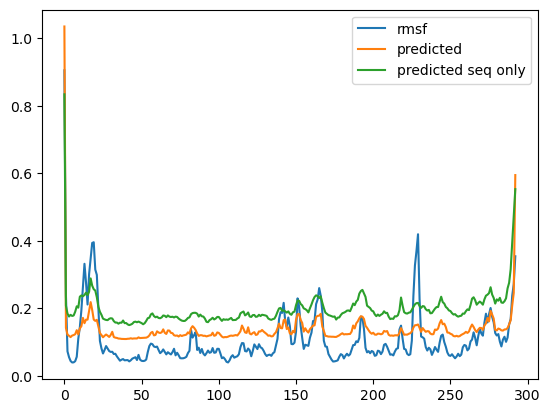

In [24]:
SAMPLE_I = 150

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

f, rmsf = adl.train_data[SAMPLE_I]
key = adl.dataset.samples[adl.train_data.indices[SAMPLE_I]]
with torch.no_grad():
        yhat_both = fmnew([x.unsqueeze(0) for x in f]).squeeze()
        yhat_seqonly = fmnew((f[0].unsqueeze(0), torch.zeros_like(f[1]).unsqueeze(0))).squeeze()

bf_both = yhat_both.detach().cpu().numpy().squeeze()
bf_seqonly = yhat_seqonly.detach().cpu().numpy().squeeze()

plt.plot(rmsf,label="rmsf")
plt.plot(bf_both,label="predicted")
plt.plot(bf_seqonly,label="predicted seq only")
plt.legend()


from scipy.stats import spearmanr, pearsonr
spearman = spearmanr(rmsf, bf_both)
pearson = pearsonr(rmsf, bf_both)
mse = ((rmsf - bf_both)**2).mean()
logger.info(f"Protein: {key}")
logger.info(f"Spearman: {spearman}")
logger.info(f"Pearson: {pearson}")
logger.info(f"MSE: {mse}")

plt.show()

In [25]:
import mdtraj as md
import nglview as nv

In [26]:
pdb_code, rep = key.split("/")
traj = md.load_xtc(ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc", top=ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb")

In [29]:
from rocketshp.plot import display_trajectory, value_to_hex
import nglview as nv


view = display_trajectory(traj, bfactor=bf_both, coloring="bfactor", normalize=True)
view

NGLWidget(max_frame=10000)